# k-NN Classifier

In [1]:
import numpy as np
import pandas as pd
import sklearn.metrics as skm
import sklearn.preprocessing as skp
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import data, remove NaN
lego_colors_by_set_full = pd.read_excel('https://drive.google.com/uc?export=download&id=1EppL5Cy4YSND45x--HV3yKavszTu2ALB')
lego_colors_by_set_full.fillna(0, inplace=True)

# For this datathon we'll just focus on 10 of the most popular themes.
lego_colors_by_set = lego_colors_by_set_full[(lego_colors_by_set_full["Theme"] == "Technic") | 
                        (lego_colors_by_set_full["Theme"] == "Friends") |
                        (lego_colors_by_set_full["Theme"] == "City") |
                        (lego_colors_by_set_full["Theme"] == "Basic Set") |
                        (lego_colors_by_set_full["Theme"] == "Creator") |
                        (lego_colors_by_set_full["Theme"] == "Duplo") |
                        (lego_colors_by_set_full["Theme"] == "Star Wars") |
                        (lego_colors_by_set_full["Theme"] == "Ninjago") |
                        (lego_colors_by_set_full["Theme"] == "Construction") |
                        (lego_colors_by_set_full["Theme"] == "Airport")]

In [3]:
# Creates a copy of the dataframe where color counts are normalized 
#  so each gives the % of parts in the set with that color, rather than the total count.

lego_theme_df = lego_colors_by_set.copy()
lego_theme_df = lego_theme_df.drop([ 'Set Name', 'Set Num', 'Theme', 'Year', 'Num Parts'], axis=1)
lego_theme_df = lego_theme_df.div(lego_theme_df.sum(axis=1), axis=0)
lego_theme_df['num_colors'] = np.count_nonzero(lego_theme_df, axis=1)
lego_theme_df["Num Parts"] = lego_colors_by_set["Num Parts"]
lego_theme_df["Theme"] = lego_colors_by_set["Theme"]

In [4]:
x = lego_theme_df.drop(['Theme'], axis=1)
y = lego_theme_df['Theme']

scaler = skp.StandardScaler()

x_standard = scaler.fit_transform(x)
x_standard = pd.DataFrame(x_standard)
x_standard.columns = x.columns

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x_standard,y,train_size=0.8,random_state=2023)

In [6]:
maks_k = 20

cross_validation_acc = pd.DataFrame(columns=['k', 'Train_Accuracy', 'Cross_Val_Accuracy'])

for n in range(2, maks_k):
    Lego_KNN = KNeighborsClassifier(n_neighbors=n)
    Lego_KNN.fit(x_train, y_train)
    train_pred = Lego_KNN.predict(x_train)
    acc_train = skm.accuracy_score(y_true=y_train, y_pred=train_pred)
    acc_cross = np.average(cross_val_score(Lego_KNN, x_train, y_train, cv=10, scoring='accuracy'))
    cross_validation_acc.loc[len(cross_validation_acc)] = [n, acc_train, acc_cross]

a = cross_validation_acc[cross_validation_acc.Cross_Val_Accuracy == cross_validation_acc.Cross_Val_Accuracy.max()]
best_k = int(a.k)

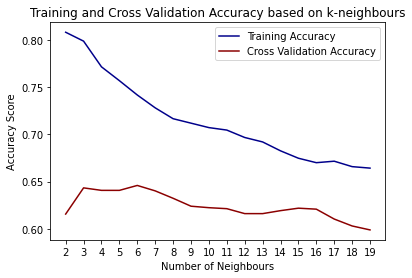

In [8]:
plt.plot(cross_validation_acc.k, 
         cross_validation_acc.Train_Accuracy, 
         label = 'Training Accuracy', 
         color="darkblue")
plt.plot(cross_validation_acc.k, 
         cross_validation_acc.Cross_Val_Accuracy, 
         label = 'Cross Validation Accuracy',
         color="darkred")
plt.title('Training and Cross Validation Accuracy based on k-neighbours')
plt.xlabel('Number of Neighbours')
plt.ylabel('Accuracy Score')
plt.xticks(range(2,maks_k))
plt.legend()
plt.show()

In [9]:
Lego_KNN = KNeighborsClassifier(n_neighbors=best_k)
Lego_KNN.fit(x_train, y_train)
KNN_Test_Predictions = Lego_KNN.predict(x_test)
ac = skm.accuracy_score(y_true=y_test, y_pred=KNN_Test_Predictions)
pr = skm.precision_score(y_true=y_test, y_pred=KNN_Test_Predictions, average='weighted')
re = skm.recall_score(y_true=y_test, y_pred=KNN_Test_Predictions, average='weighted')
f1 = skm.f1_score(y_true=y_test, y_pred=KNN_Test_Predictions, average='weighted')

KNN_Test_Performance_Metrics = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1-Score'])
KNN_Test_Performance_Metrics.loc[len(KNN_Test_Performance_Metrics)] = [ac, pr, re, f1]
KNN_Test_Performance_Metrics

,Accuracy,Precision,Recall,F1-Score
0,0.635983,0.636667,0.635983,0.628045


In [10]:
KNN_Confusion_Matrix = skm.confusion_matrix(y_true=y_test, y_pred=KNN_Test_Predictions,normalize='true')
KNN_Confusion_Matrix = pd.DataFrame(KNN_Confusion_Matrix)
KNN_Confusion_Matrix.columns = Lego_KNN.classes_
KNN_Confusion_Matrix = KNN_Confusion_Matrix.unstack()
KNN_Confusion_Matrix = KNN_Confusion_Matrix.reset_index()
KNN_Confusion_Matrix.columns = ['Class1', 'Class2', 'Predictions']
KNN_Confusion_Matrix['Class2'] = list(Lego_KNN.classes_)*10

In [11]:
cross_validation_acc.to_excel('KNN_Cross_Validation_Acc.xlsx', sheet_name='KNN_CV')
KNN_Test_Performance_Metrics.to_excel('KNN_Test_Performance_Metrics.xlsx', sheet_name='KNN_PM')
KNN_Confusion_Matrix.to_excel('KNN_Confusion_Matrix.xlsx', sheet_name='KNN_CM')

# Naive Bayes Classification

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


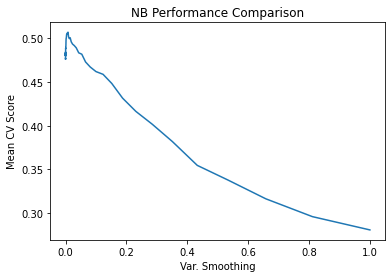

In [12]:
np.random.seed(2023)
Lego_GNB = GaussianNB()
params_GNB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=Lego_GNB, 
                     param_grid=params_GNB, 
                     cv=10,
                     verbose=1, 
                     scoring='accuracy')

gs_NB.fit(x_train, y_train)

results_NB = pd.DataFrame(gs_NB.cv_results_['params'])
results_NB['test_score'] = gs_NB.cv_results_['mean_test_score']

plt.plot(results_NB['var_smoothing'], results_NB['test_score'])    
plt.xlabel('Var. Smoothing')
plt.ylabel("Mean CV Score")
plt.title("NB Performance Comparison")
plt.show()

In [13]:
best_var_smooth = gs_NB.best_params_['var_smoothing']
Lego_GNB = GaussianNB(var_smoothing=best_var_smooth)
Lego_GNB.fit(x_train, y_train)
GNB_Test_Predictions = Lego_GNB.predict(x_test)

ac = skm.accuracy_score(y_true=y_test, y_pred=GNB_Test_Predictions)
pr = skm.precision_score(y_true=y_test, y_pred=GNB_Test_Predictions, average='weighted')
re = skm.recall_score(y_true=y_test, y_pred=GNB_Test_Predictions, average='weighted')
f1 = skm.f1_score(y_true=y_test, y_pred=GNB_Test_Predictions, average='weighted')

GNB_Test_Performance_Metrics = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1-Score'])
GNB_Test_Performance_Metrics.loc[len(GNB_Test_Performance_Metrics)] = [ac, pr, re, f1]
GNB_Test_Performance_Metrics

,Accuracy,Precision,Recall,F1-Score
0,0.5,0.518393,0.5,0.461594


In [14]:
GNB_Confusion_Matrix = skm.confusion_matrix(y_true=y_test, y_pred=GNB_Test_Predictions,normalize='true')
GNB_Confusion_Matrix = pd.DataFrame(GNB_Confusion_Matrix)
GNB_Confusion_Matrix.columns = Lego_GNB.classes_
GNB_Confusion_Matrix = GNB_Confusion_Matrix.unstack()
GNB_Confusion_Matrix = GNB_Confusion_Matrix.reset_index()
GNB_Confusion_Matrix.columns = ['Class1', 'Class2', 'Predictions']
GNB_Confusion_Matrix['Class2'] = list(Lego_KNN.classes_)*10

,Class1,Class2,Predictions
0,Airport,Airport,0.473684
1,Airport,Basic Set,0.085106
2,Airport,City,0.090909
3,Airport,Construction,0.045455
4,Airport,Creator,0.160000
...,...,...,...
95,Technic,Duplo,0.046512
96,Technic,Friends,0.039216
97,Technic,Ninjago,0.027027
98,Technic,Star Wars,0.075000


In [15]:
results_NB.to_excel('GNB_Cross_Validation_Acc.xlsx', sheet_name='GNB_CV')
GNB_Test_Performance_Metrics.to_excel('GNB_Test_Performance_Metrics.xlsx', sheet_name='GNB_PM')
GNB_Confusion_Matrix.to_excel('GNB_Confusion_Matrix.xlsx', sheet_name='GNB_CM')

# Neural Network

In [25]:
from sklearn.neural_network import MLPClassifier
import numpy as np
Lego_MLP = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(5,), (10,), (15,)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.001, 0.05, 0.1, 0.15, 0.20],
    'learning_rate': ['invscaling', 'constant','adaptive']}
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(Lego_MLP, parameter_space, n_jobs=-1, cv=5)
clf.fit(x_train, y_train)

In [ ]:
clf.best_params_
clf.best_score_

# Lego Parts By Year

In [51]:
import plotly.express as px
themes = lego_colors_by_set.Theme.unique()
for theme in themes:
    lego1 = lego_colors_by_set[lego_colors_by_set.Theme == theme]
    lego = lego1[['Year', 'Num Parts']]
    lego_summary = lego.groupby(by=["Year"]).mean()
    lego_summary = lego_summary.reset_index()
    lego_summary.columns = ['Year', 'Num_Parts']
    fig = px.line(lego_summary,
            x = lego_summary.Year,
            y = lego_summary.Num_Parts,
            title=theme)
    fig.show()

In [61]:
lego = lego_colors_by_set[['Year', 'Num Parts']]
lego_summary = lego.groupby(by=["Year"]).mean()
lego_summary = lego_summary.reset_index()
lego_summary.columns = ['Year', 'Num_Parts']
fig = px.scatter(lego_summary,
                 x = lego_summary.Year,
                 y = lego_summary.Num_Parts,
                 trendline='ols',
                 trendline_color_override="darkred",
                 title = 'Average Number of Parts in Lego Sets',
                 labels={"Year": "Year",
                         "Num_Parts": "Average Number of Parts"})
fig.show()